In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats

df = pd.read_csv('auto_price.csv')
print("Data shape:", df.shape)


Data shape: (18286, 24)


In [3]:
missing_percentage = (df.isnull().mean() * 100).sort_values()
missing_percentage

Unnamed: 0              0.000000
Gearing_Type            6.999891
Horsepower              6.999891
Age                     6.999891
Mileage                 8.995953
Weight                 10.997484
Make_Model             11.998250
Body_Type              11.998250
Price                  17.997375
Type                   20.999672
Comfort_Convenience    22.995734
Displacement           26.998797
Gears                  27.999563
Cons_Comb              31.997156
Drive_Chain            32.997922
Inspection_New         34.999453
Vat                    34.999453
Fuel                   38.997047
Previous_Owners        45.996938
Entertainment_Media    52.996828
Paint_Type             56.999891
Safety_Security        71.994969
Upholstery_Type        82.997922
Extras                 84.999453
dtype: float64

In [4]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        print(f"Filling missing values in numeric column {col} (using median: {df[col].median()})")
        df[col] = df[col].fillna(df[col].median())

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        print(f"Filling missing values in categorical column {col} (using mode: {mode_value})")
        df[col] = df[col].fillna(mode_value)

print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)


Filling missing values in numeric column Gears (using median: 6.0)
Filling missing values in numeric column Age (using median: 1.0)
Filling missing values in numeric column Previous_Owners (using median: 1.0)
Filling missing values in numeric column Inspection_New (using median: 0.0)
Filling missing values in numeric column Cons_Comb (using median: 4.8)
Filling missing values in categorical column Make_Model (using mode: Audi A3)
Filling missing values in categorical column Body_Type (using mode: Sedans)
Filling missing values in categorical column Price (using mode: $10990.0)
Filling missing values in categorical column Vat (using mode: VAT deductible)
Filling missing values in categorical column Mileage (using mode: 10.0 km)
Filling missing values in categorical column Type (using mode: Used)
Filling missing values in categorical column Fuel (using mode: Benzine)
Filling missing values in categorical column Comfort_Convenience (using mode: Air conditioning,Electrical side mirrors,Hil

In [5]:
def standardize_price(price_str):
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str)
    if '€' in price_str:
        numeric_value = float(price_str.replace('€', '').replace(',', '').strip())
        return numeric_value * 1.1
    elif '£' in price_str:
        numeric_value = float(price_str.replace('£', '').replace(',', '').strip())
        return numeric_value * 1.3
    else:
        return float(price_str.replace('$', '').replace(',', '').strip())

df['Price_Value'] = df['Price'].apply(standardize_price)
df['Price'] = df['Price_Value'].apply(lambda x: f"${x:.2f}" if pd.notna(x) else np.nan)


In [6]:
def standardize_mileage(mileage_str):
    if pd.isna(mileage_str):
        return np.nan
    
    mileage_str = str(mileage_str)
    
    import re
    numeric_match = re.search(r'([\d,.]+)', mileage_str)
    if not numeric_match:
        return np.nan
        
    numeric_value = float(numeric_match.group(1).replace(',', ''))
    
    if 'mi' in mileage_str:
        return numeric_value * 1.60934
    else:
        return numeric_value

df['Mileage_Value'] = df['Mileage'].apply(standardize_mileage)
df['Mileage'] = df['Mileage_Value'].apply(lambda x: f"{x:.2f} km" if pd.notna(x) else np.nan)


In [7]:
def standardize_weight(weight_str):
    if pd.isna(weight_str):
        return np.nan
    
    weight_str = str(weight_str)
    
    import re
    numeric_match = re.search(r'([\d,.]+)', weight_str)
    if not numeric_match:
        return np.nan
        
    numeric_value = float(numeric_match.group(1).replace(',', ''))
    
    if 'lbs' in weight_str:
        return numeric_value * 0.453592
    elif 'g' in weight_str and not 'kg' in weight_str:
        return numeric_value / 1000
    else:
        return numeric_value

df['Weight_Value'] = df['Weight'].apply(standardize_weight)
df['Weight'] = df['Weight_Value'].apply(lambda x: f"{x:.2f} kg" if pd.notna(x) else np.nan)


In [8]:
def standardize_displacement(disp_str):
    if pd.isna(disp_str):
        return np.nan
    
    disp_str = str(disp_str)
    
    import re
    numeric_match = re.search(r'([\d,.]+)', disp_str)
    if not numeric_match:
        return np.nan
        
    numeric_value = float(numeric_match.group(1).replace(',', ''))
    
    return numeric_value

df['Displacement_Value'] = df['Displacement'].apply(standardize_displacement)
df['Displacement'] = df['Displacement_Value'].apply(lambda x: f"{x:.2f} cc" if pd.notna(x) else np.nan)


In [9]:
if 'Age' in df.columns:
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    
    age_bins = [-1, 0, 1, 2, 3, float('inf')]
    age_labels = ['New', '1 year', '2 years', '3+ years', 'Unknown']
    df['age_category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
    
    df['age_category'] = df['age_category'].fillna('Unknown')


In [10]:

has_columns = [col for col in df.columns if col.startswith('has_')]
for col in has_columns:
    df[col] = df[col].astype(bool)


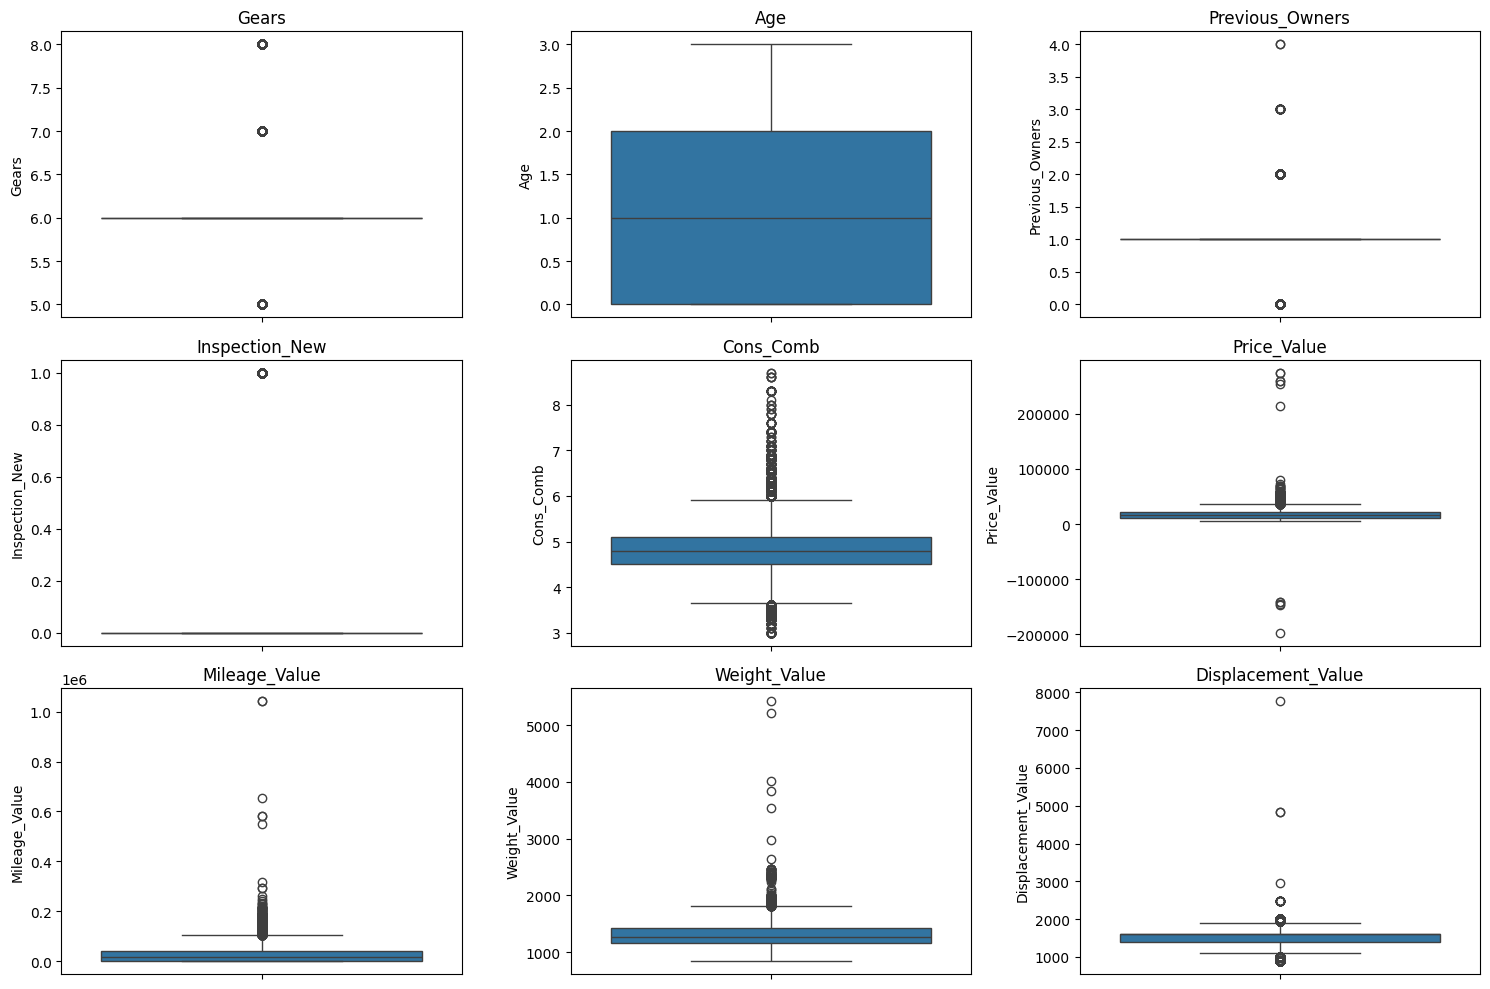

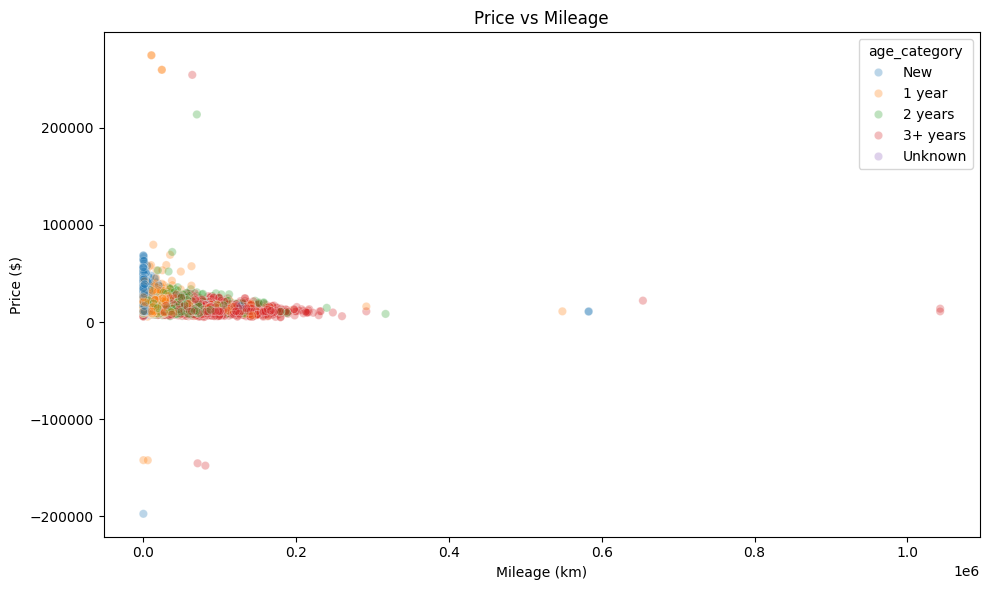

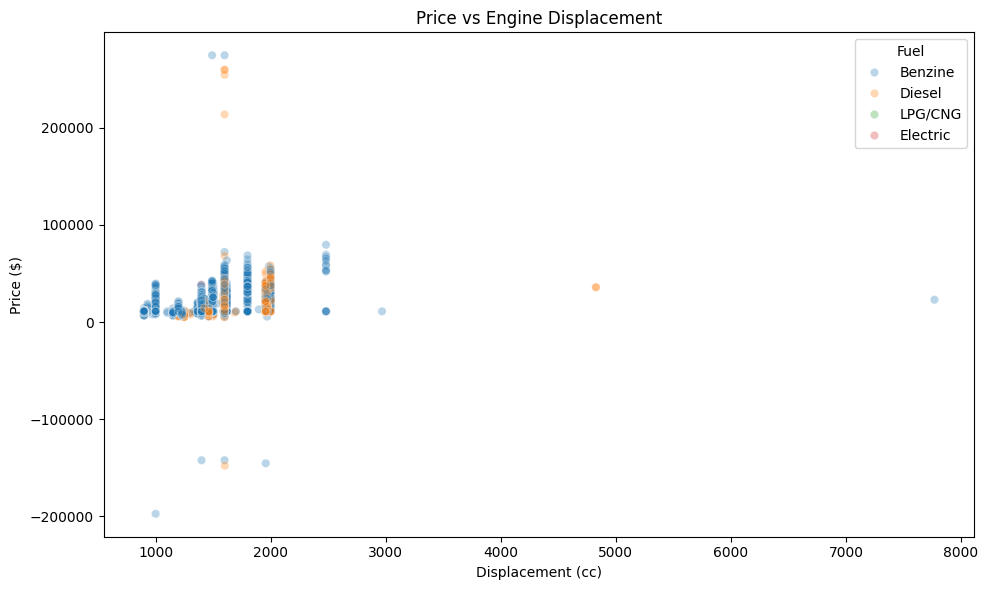

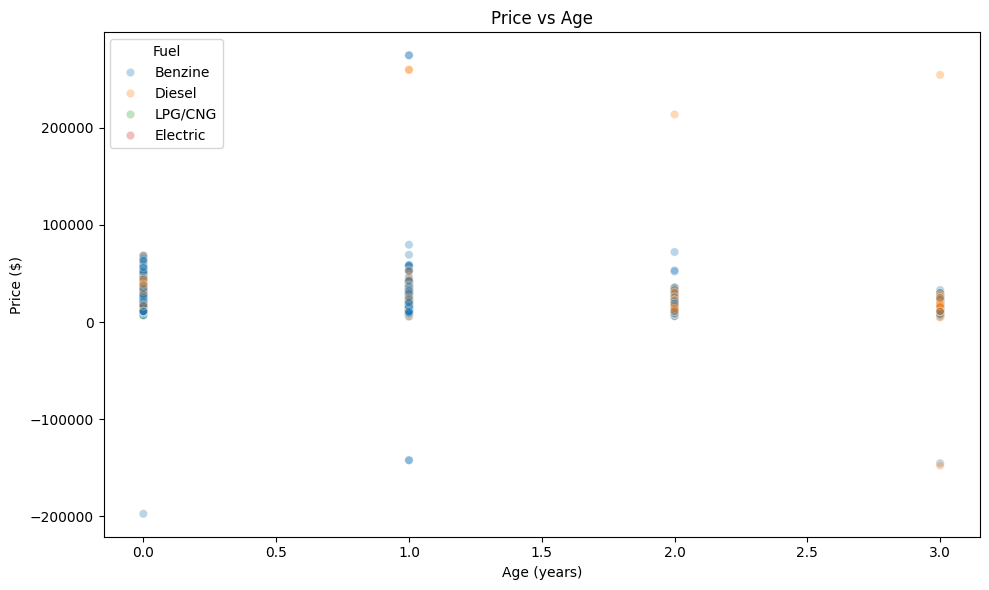

<Figure size 1500x1500 with 0 Axes>

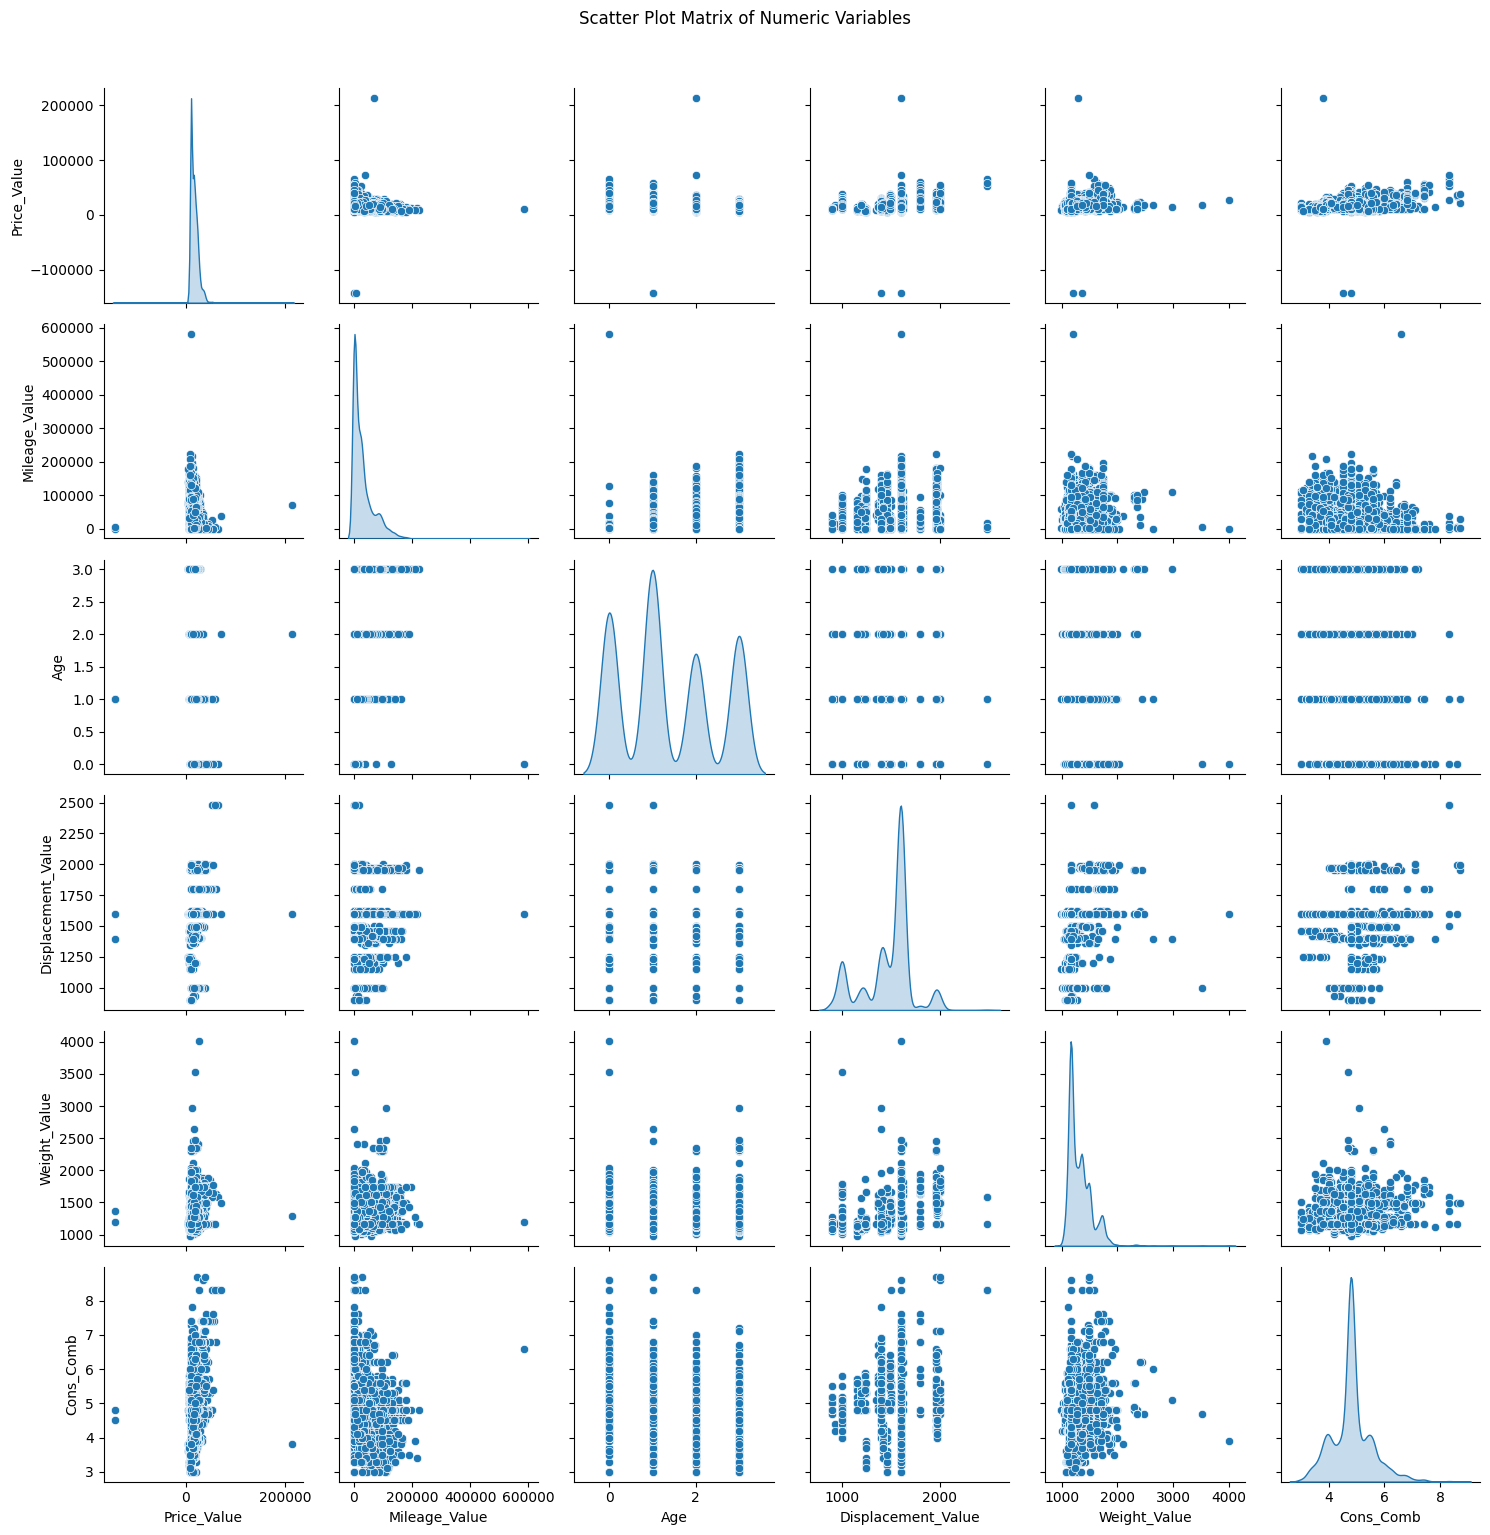

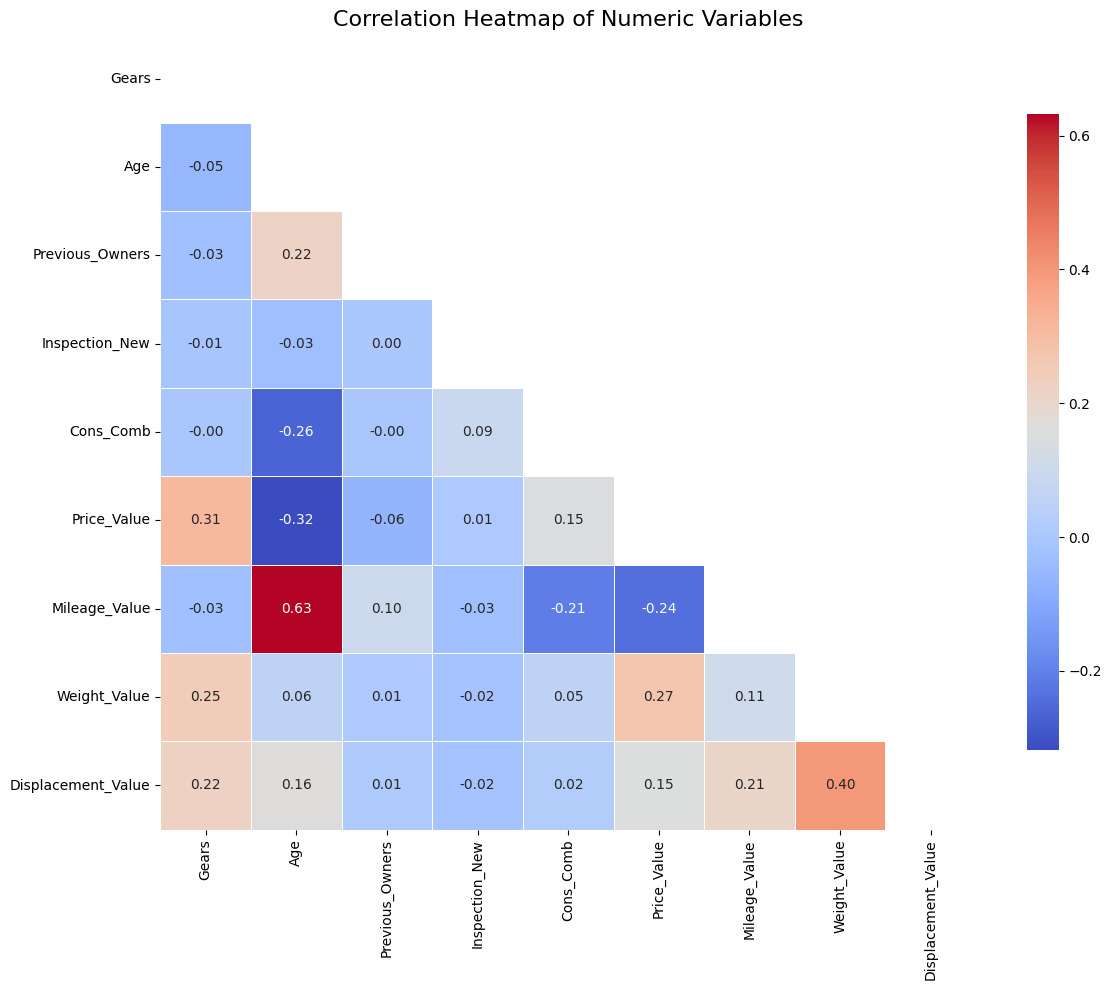

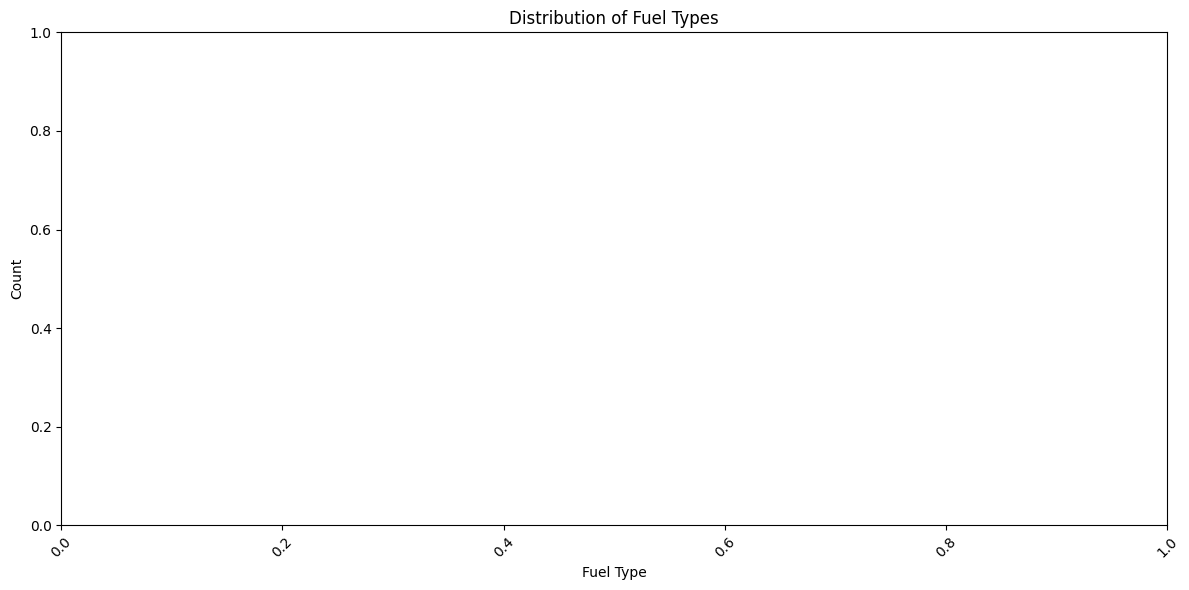

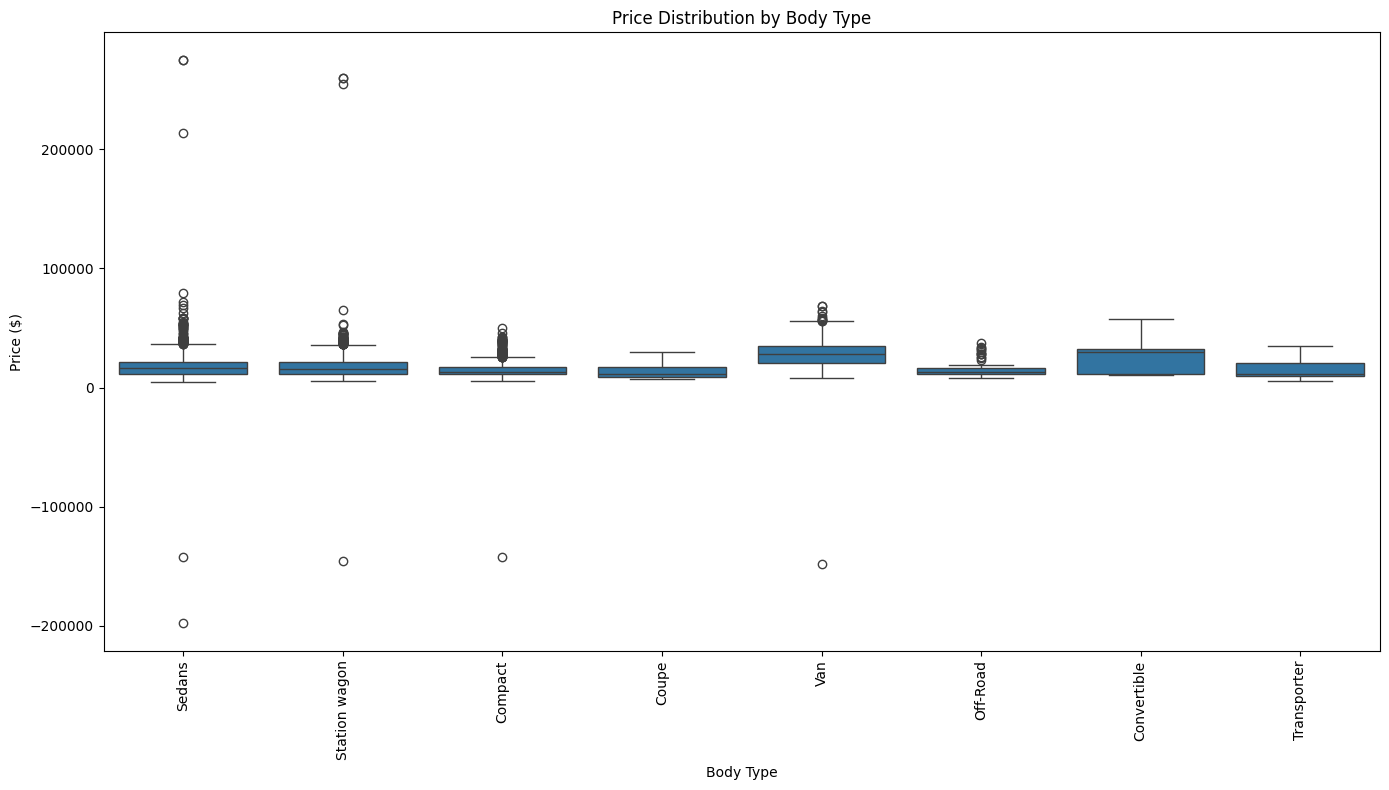

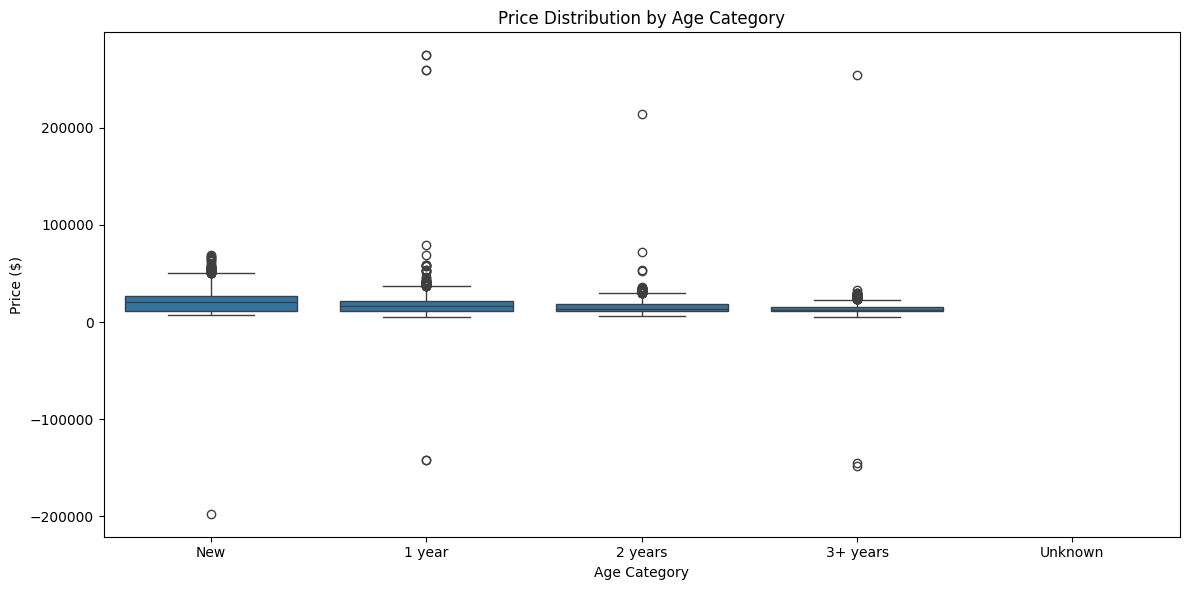

In [11]:
numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns 
                if col != 'Unnamed: 0']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:min(len(numeric_cols), 9)]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mileage_Value', y='Price_Value', data=df, alpha=0.3, hue='age_category')
plt.title('Price vs Mileage')
plt.xlabel('Mileage (km)')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Displacement_Value', y='Price_Value', data=df, alpha=0.3, hue='Fuel')
plt.title('Price vs Engine Displacement')
plt.xlabel('Displacement (cc)')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Price_Value', data=df, alpha=0.3, hue='Fuel')
plt.title('Price vs Age')
plt.xlabel('Age (years)')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

numeric_vars = ['Price_Value', 'Mileage_Value', 'Age', 'Displacement_Value', 'Weight_Value', 'Cons_Comb']
plt.figure(figsize=(15, 15))
sns.pairplot(df[numeric_vars].sample(min(5000, len(df))), diag_kind='kde')
plt.suptitle('Scatter Plot Matrix of Numeric Variables', y=1.02)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
if 'Unnamed: 0' in numeric_df.columns:
    numeric_df = numeric_df.drop('Unnamed: 0', axis=1)
    
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numeric Variables', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
fuel_columns = [col for col in df.columns if col.startswith('fuel_')]
fuel_counts = df[fuel_columns].sum().sort_values(ascending=False)
sns.barplot(x=fuel_counts.index, y=fuel_counts.values)
plt.title('Distribution of Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Body_Type', y='Price_Value', data=df)
plt.title('Price Distribution by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='age_category', y='Price_Value', data=df)
plt.title('Price Distribution by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()


In [12]:
if 'Fuel' in df.columns:
    fuel_dummies = pd.get_dummies(df['Fuel'], prefix='fuel')
    df = pd.concat([df, fuel_dummies], axis=1)

fuel_columns = [col for col in df.columns if col.startswith('fuel_')]
for col in fuel_columns:
    df[col] = df[col].astype(int)

df.to_csv('clean_auto_price.csv', index=False)
print("Cleaned data shape:", df.shape)
print("\nSample of processed data:")
df.head()


Cleaned data shape: (18286, 32)

Sample of processed data:


,Make_Model,Body_Type,Price,Vat,Mileage,Type,Fuel,Gears,Comfort_Convenience,Entertainment_Media,...,Cons_Comb,Price_Value,Mileage_Value,Weight_Value,Displacement_Value,age_category,fuel_Benzine,fuel_Diesel,fuel_Electric,fuel_LPG/CNG
0,Audi A1,Sedans,$15770.00,VAT deductible,56012.84 km,Used,Benzine,6.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",...,4.8,15770.0,56012.837299,1220.000000,1422.0,3+ years,1,0,0,0
1,Audi A1,Sedans,$10990.00,VAT deductible,80000.00 km,Used,Benzine,7.0,"Air conditioning,Automatic climate control,Hil...","Bluetooth,Hands-free equipment,On-board comput...",...,5.6,10990.0,80000.000000,1254.998346,1598.0,2 years,1,0,0,0
2,Audi A1,Sedans,$14640.00,VAT deductible,83449.77 km,Used,Diesel,7.0,"Air conditioning,Cruise control,Electrical sid...","Bluetooth,Hands-free equipment,On-board comput...",...,4.8,14640.0,83449.766849,1134.996046,1598.0,3+ years,0,1,0,0
3,Audi A1,Sedans,$10990.00,VAT deductible,72999.79 km,Used,Diesel,6.0,"Air suspension,Armrest,Auxiliary heating,Elect...","Bluetooth,Hands-free equipment,On-board comput...",...,3.8,10990.0,72999.791147,1195.000000,1598.0,3+ years,0,1,0,0
4,Audi A1,Sedans,$16790.00,VAT deductible,16200.00 km,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,4.1,16790.0,16200.000000,1135.000000,1598.0,3+ years,0,1,0,0
